In [512]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import PIL
import shutil
import zipfile
import glob
import os
import time

파일 설정, device는 cuda로

In [513]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataDir = './dataset/AI-DATASET/data'

trainData_dir = os.path.join(dataDir, 'trainData')
train_dir = os.path.join(dataDir, 'train')
test_dir = os.path.join(dataDir, 'test')

beverage_dir = os.path.join(trainData_dir, 'beverage')
dailynecessity_dir = os.path.join(trainData_dir, 'dailynecessity')
iceCream_dir = os.path.join(trainData_dir, 'iceCream')
instanceFood_dir = os.path.join(trainData_dir, 'instanceFood')
Snack_dir = os.path.join(trainData_dir, 'Snack')


beverage_files = [f'beverage.{i}.jpg' for i in range(1,  501)]
dailynecessity_files = [f'dailynecessity.{i}.jpg' for i in range(1, 501
)]
iceCream_files = [f'iceCream.{i}.jpg' for i in range(1, 501)]
instanceFood_files = [f'instanceFood.{i}.jpg' for i in range(1, 501)]
Snack_files = [f'Snack.{i}.jpg' for i in range(1, 501)]


"""
train, valid, test 폴더 생성
"""
train_set_dir = os.path.join(train_dir, 'train')
# os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
# os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
# os.mkdir(test_set_dir)
"""

for beverage, dailynecessity, iceCream, instanceFood, snack in zip(beverage_files[:300], dailynecessity_files[:300], iceCream_files[:300], instanceFood_files[:300], Snack_files[:300]):
    src = os.path.join(train_dir, beverage)
    dst = os.path.join(train_set_dir, beverage)
    shutil.move(src, dst)

    src = os.path.join(train_dir, dailynecessity)
    dst = os.path.join(train_set_dir, dailynecessity)
    shutil.move(src, dst)

    src = os.path.join(train_dir, iceCream)
    dst = os.path.join(train_set_dir, iceCream)
    shutil.move(src, dst)
    
    
    src = os.path.join(train_dir, instanceFood)
    dst = os.path.join(train_set_dir, instanceFood)
    shutil.move(src, dst)

    src = os.path.join(train_dir, snack)
    dst = os.path.join(train_set_dir, snack)
    shutil.move(src, dst)

for beverage, dailynecessity, iceCream, instanceFood, snack in zip(beverage_files[300:400], dailynecessity_files[300:400], iceCream_files[300:400], instanceFood_files[300:400], Snack_files[300:400]):
    src = os.path.join(train_dir, beverage)
    dst = os.path.join(valid_set_dir, beverage)
    shutil.move(src, dst)

    src = os.path.join(train_dir, dailynecessity)
    dst = os.path.join(valid_set_dir, dailynecessity)
    shutil.move(src, dst)

    src = os.path.join(train_dir, iceCream)
    dst = os.path.join(valid_set_dir, iceCream)
    shutil.move(src, dst)
    
    
    src = os.path.join(train_dir, instanceFood)
    dst = os.path.join(valid_set_dir, instanceFood)
    shutil.move(src, dst)

    src = os.path.join(train_dir, snack)
    dst = os.path.join(valid_set_dir, snack)
    shutil.move(src, dst)

for beverage, dailynecessity, iceCream, instanceFood, snack in zip(beverage_files[400:500], dailynecessity_files[400:500], iceCream_files[400:500], instanceFood_files[400:500], Snack_files[400:500]):
    src = os.path.join(train_dir, beverage)
    dst = os.path.join(test_set_dir, beverage)
    shutil.move(src, dst)

    src = os.path.join(train_dir, dailynecessity)
    dst = os.path.join(test_set_dir, dailynecessity)
    shutil.move(src, dst)

    src = os.path.join(train_dir, iceCream)
    dst = os.path.join(test_set_dir, iceCream)
    shutil.move(src, dst)
    
    
    src = os.path.join(train_dir, instanceFood)
    dst = os.path.join(test_set_dir, instanceFood)
    shutil.move(src, dst)

    src = os.path.join(train_dir, snack)
    dst = os.path.join(test_set_dir, snack)
    shutil.move(src, dst)
        """

'\n\nfor beverage, dailynecessity, iceCream, instanceFood, snack in zip(beverage_files[:300], dailynecessity_files[:300], iceCream_files[:300], instanceFood_files[:300], Snack_files[:300]):\n    src = os.path.join(train_dir, beverage)\n    dst = os.path.join(train_set_dir, beverage)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, dailynecessity)\n    dst = os.path.join(train_set_dir, dailynecessity)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, iceCream)\n    dst = os.path.join(train_set_dir, iceCream)\n    shutil.move(src, dst)\n    \n    \n    src = os.path.join(train_dir, instanceFood)\n    dst = os.path.join(train_set_dir, instanceFood)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, snack)\n    dst = os.path.join(train_set_dir, snack)\n    shutil.move(src, dst)\n\nfor beverage, dailynecessity, iceCream, instanceFood, snack in zip(beverage_files[300:400], dailynecessity_files[300:400], iceCream_files[300:400], instanceFood_files[300

In [514]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        if 'beverage' in files[0]:
            self.label = 0
        elif 'dailynecessity' in files[0]:
            self.label = 1
        elif 'iceCream' in files[0]:
            self.label = 2
        elif 'instanceFood' in files[0]:
            self.label = 3
        elif 'Snack' in files[0]:
            self.label = 4
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))

        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

사용할 모델

In [515]:
model = torchvision.models.resnet50(weights=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.cuda()
summary(model, input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

모델 설정 및 정상적인 파싱 확인

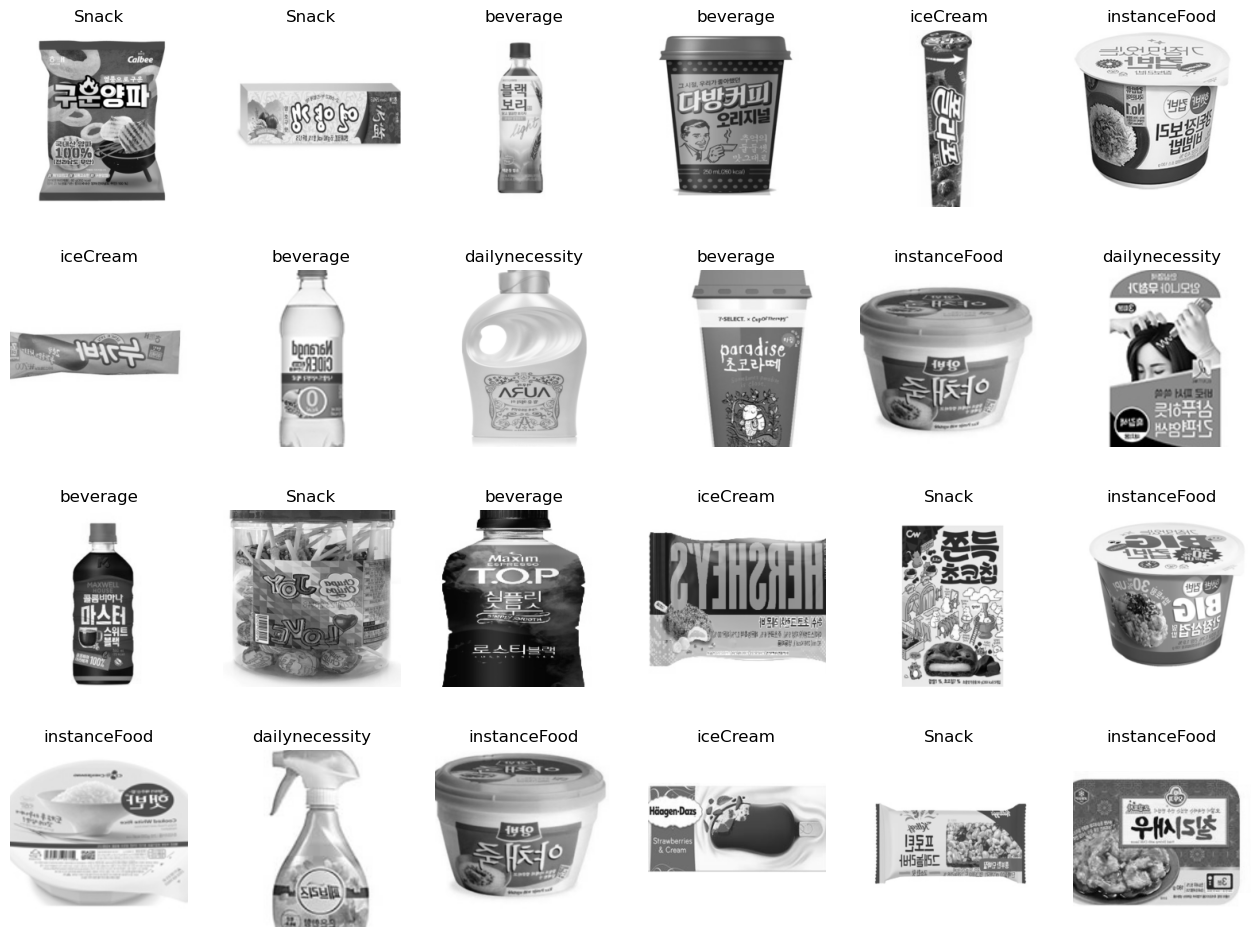

In [516]:


train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])


train_beverage_dataset = CustomDataset(beverage_files[:300], train_set_dir, transform=train_transform)
train_dailynecessity_dataset = CustomDataset(dailynecessity_files[:300], train_set_dir, transform=train_transform)
train_iceCream_dataset = CustomDataset(iceCream_files[:300], train_set_dir, transform=train_transform)
train_instanceFoods_dataset = CustomDataset(instanceFood_files[:300], train_set_dir, transform=train_transform)
train_Snack_dataset = CustomDataset(Snack_files[:300], train_set_dir, transform=train_transform)
train_dataset = torch.utils.data.ConcatDataset([train_beverage_dataset, train_dailynecessity_dataset, train_iceCream_dataset, train_instanceFoods_dataset, train_Snack_dataset])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_beverage_dataset = CustomDataset(beverage_files[300:400], valid_set_dir, transform=test_transform)
valid_dailynecessity_dataset = CustomDataset(dailynecessity_files[300:400], valid_set_dir, transform=test_transform)
valid_iceCream_dataset = CustomDataset(iceCream_files[300:400], valid_set_dir, transform=test_transform)
valid_instanceFoods_dataset = CustomDataset(instanceFood_files[300:400], valid_set_dir, transform=test_transform)
valid_Snack_dataset = CustomDataset(Snack_files[300:400], valid_set_dir, transform=test_transform)
valid_dataset = torch.utils.data.ConcatDataset([valid_beverage_dataset, valid_dailynecessity_dataset, valid_iceCream_dataset, valid_instanceFoods_dataset, valid_Snack_dataset])
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)


test_beverage_dataset = CustomDataset(beverage_files[400:], test_set_dir, transform=test_transform)
test_dailynecessity_dataset = CustomDataset(dailynecessity_files[:400], test_set_dir, transform=test_transform)
test_iceCream_dataset = CustomDataset(iceCream_files[400:], valid_set_dir, transform=test_transform)
test_instanceFoods_dataset = CustomDataset(instanceFood_files[400:], test_set_dir, transform=test_transform)
test_Snack_dataset = CustomDataset(Snack_files[400:], test_set_dir, transform=test_transform)
test_dataset = torch.utils.data.ConcatDataset([test_beverage_dataset, test_dailynecessity_dataset, test_iceCream_dataset, test_instanceFoods_dataset, test_Snack_dataset])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


samples, labels = iter(train_loader).__next__()
classes = {0:'beverage', 1:'dailynecessity', 2:'iceCream', 3:'instanceFood', 4: 'Snack'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [517]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

58.565sec : [Epoch 1/10] -> train loss: -2.9169, train acc: 19.867% / valid loss: -7.3121, valid acc: 20.000%
91.059sec : [Epoch 2/10] -> train loss: -49.0990, train acc: 20.000% / valid loss: -86.9076, valid acc: 20.000%
37.816sec : [Epoch 3/10] -> train loss: -103.9965, train acc: 20.000% / valid loss: -100.4350, valid acc: 20.000%
37.190sec : [Epoch 4/10] -> train loss: -113.9394, train acc: 20.000% / valid loss: -104.5610, valid acc: 20.000%
43.750sec : [Epoch 5/10] -> train loss: -113.7732, train acc: 20.000% / valid loss: -109.9735, valid acc: 20.000%
55.903sec : [Epoch 6/10] -> train loss: -114.3633, train acc: 20.000% / valid loss: -108.1643, valid acc: 20.000%
47.173sec : [Epoch 7/10] -> train loss: -115.8186, train acc: 20.000% / valid loss: -106.6259, valid acc: 20.000%
39.073sec : [Epoch 8/10] -> train loss: -116.9870, train acc: 20.000% / valid loss: -108.7771, valid acc: 20.000%
38.291sec : [Epoch 9/10] -> train loss: -116.8748, train acc: 20.000% / valid loss: -112.1531,

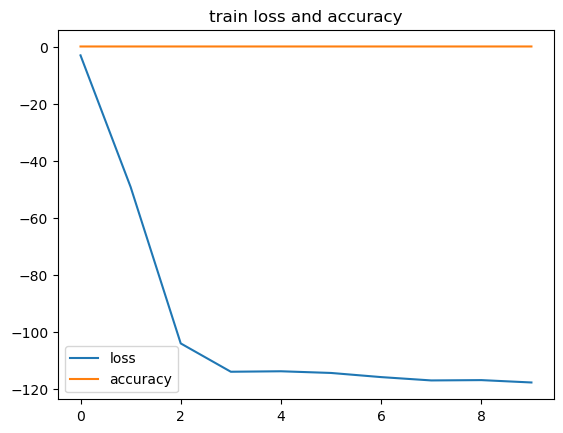

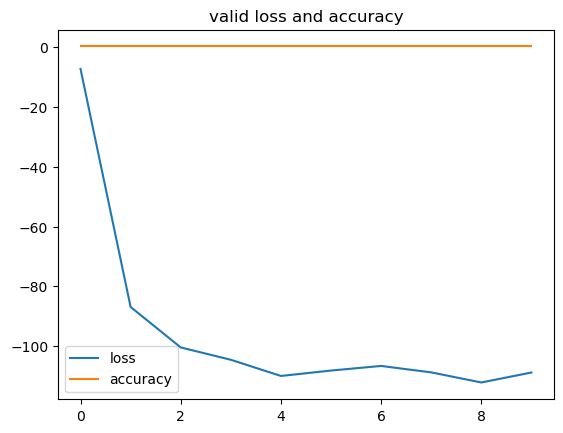

FileNotFoundError: [Errno 2] No such file or directory: './dataset/AI-DATASET/data\\train\\test\\dailynecessity.44.jpg'

In [518]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
 
fit(model, criterion, optimizer, 10, train_loader, valid_loader)
eval(model, criterion, test_loader)
